In [1]:
import os
import gc
import glob
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Make sure to install tqdm if you haven't (pip install tqdm)


In [2]:
def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df


In [3]:
# Specify the directory where CSV files are located
results_directory = "../Results/Summary/"

# Use os.path.join for path construction
csv_files = glob.glob(os.path.join(results_directory, '*_summary_MI_func.csv'))

# Use tqdm to add a progress bar during concatenation
dfs = []
for csv_file in tqdm(csv_files, desc='Reading CSV files', unit='file'):
    df = pd.read_csv(csv_file, index_col=[0])
    dfs.append(df)

# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

# Display the concatenated DataFrame
df.head()


Reading CSV files: 100%|██████████| 6/6 [00:01<00:00,  5.99file/s]


,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,0,FYB1,0.037944,3.703762e-03,0.073832,9.137931e-08,0.003988,0.133517,0.048471,C73_C1_VISIUM,Liver_visium,hist2st
1,1,MME,0.248987,1.493047e-71,0.303691,4.709541e-107,0.116664,0.552686,0.250680,C73_C1_VISIUM,Liver_visium,hist2st
2,2,CKAP5,0.082806,2.426433e-09,0.106306,2.710782e-14,0.006528,0.213023,0.080914,C73_C1_VISIUM,Liver_visium,hist2st
3,3,MAP2K1,0.291781,1.266866e-98,0.336820,1.148629e-132,0.138727,0.605552,0.289929,C73_C1_VISIUM,Liver_visium,hist2st
4,4,CAST,0.179371,1.397628e-37,0.254622,7.741252e-75,0.065898,0.526105,0.173970,C73_C1_VISIUM,Liver_visium,hist2st


In [4]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)


# Figure2

In [5]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res/"

# List of dataset names
datasets = ["Skin_Melanoma", "BC_Her2ST", "Liver_visium", "Skin_cSCC", "Kidney_visium", "BC_visium"]

# Iterate over datasets
for dataset_name in datasets:
    # Read the functional gene results for the current dataset
    df_func = pd.read_csv(os.path.join(functional_results_directory, f"{dataset_name}_summary_MI_func.csv"))

    # List of methods
    methods = ["deeppt", "hist2st", "histogene", "stimage", "bleep", "stnet", "deepspace"]

    # Get predictable genes for each method
    predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

    # Find the intersection of predictable genes across all methods
    predictable_genes = list(set.intersection(*predictable_genes_sets))
    print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

    # Subset the original DataFrame for predictable genes
    df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

    # Save the results for predictable genes
    predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_func.csv")
    df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*_func.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


There are 152 genes that are predictable by all methods for Skin_Melanoma.
There are 115 genes that are predictable by all methods for BC_Her2ST.
There are 395 genes that are predictable by all methods for Liver_visium.
There are 110 genes that are predictable by all methods for Skin_cSCC.
There are 6 genes that are predictable by all methods for Kidney_visium.
There are 58 genes that are predictable by all methods for BC_visium.


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,1,1,CD14,0.052389,0.105855,0.038065,0.182173,0.019641,0.869125,0.000367,E2,BC_Her2ST,histogene
1,2,2,NOTCH1,0.026907,0.260726,0.015441,0.356486,0.007120,0.407320,-0.000910,E2,BC_Her2ST,histogene
2,11,11,NASP,0.012331,0.384469,0.007353,0.430473,0.005341,0.508852,0.000090,E2,BC_Her2ST,histogene
3,32,32,CHD4,0.056062,0.090683,0.063133,0.066102,0.011459,0.724654,0.009052,E2,BC_Her2ST,histogene
4,36,36,MAP2K2,0.056650,0.088411,0.094045,0.012373,0.016546,0.883509,-0.021904,E2,BC_Her2ST,histogene
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58501,70456,592,ERRFI1,-0.080417,0.999893,-0.074347,0.999689,-0.007288,0.723622,-0.065221,C,Kidney_visium,histogene
58502,70595,731,CCND1,-0.108895,1.000000,-0.086727,0.999967,-0.021682,0.907696,-0.118889,C,Kidney_visium,histogene
58503,70731,867,SPP1,-0.089322,0.999981,-0.045839,0.982484,-0.017751,0.978358,-0.094656,C,Kidney_visium,histogene
58504,70972,1108,S100A10,-0.128494,1.000000,-0.112256,1.000000,-0.033374,0.944595,-0.132830,C,Kidney_visium,histogene


In [ ]:
# for dataset_name in ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']:
#     res = list(df_combined_predictable[df_combined_predictable["Dataset"]==dataset_name].Gene.unique())
   
#     # Specify the file path
#     file_path = f'../Dataset/Gene_list/predictable_genes_{dataset_name}_func.txt'
    
#     # Open the file in write mode
#     with open(file_path, 'w') as file:
#         # Write each item in the list to a new line in the file
#         for item in res:
#             file.write(f"{item}\n")
    
#     print(f"List has been written to {file_path}")


In [6]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df_combined_predictable.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=dataset_order, ordered=True)
df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)


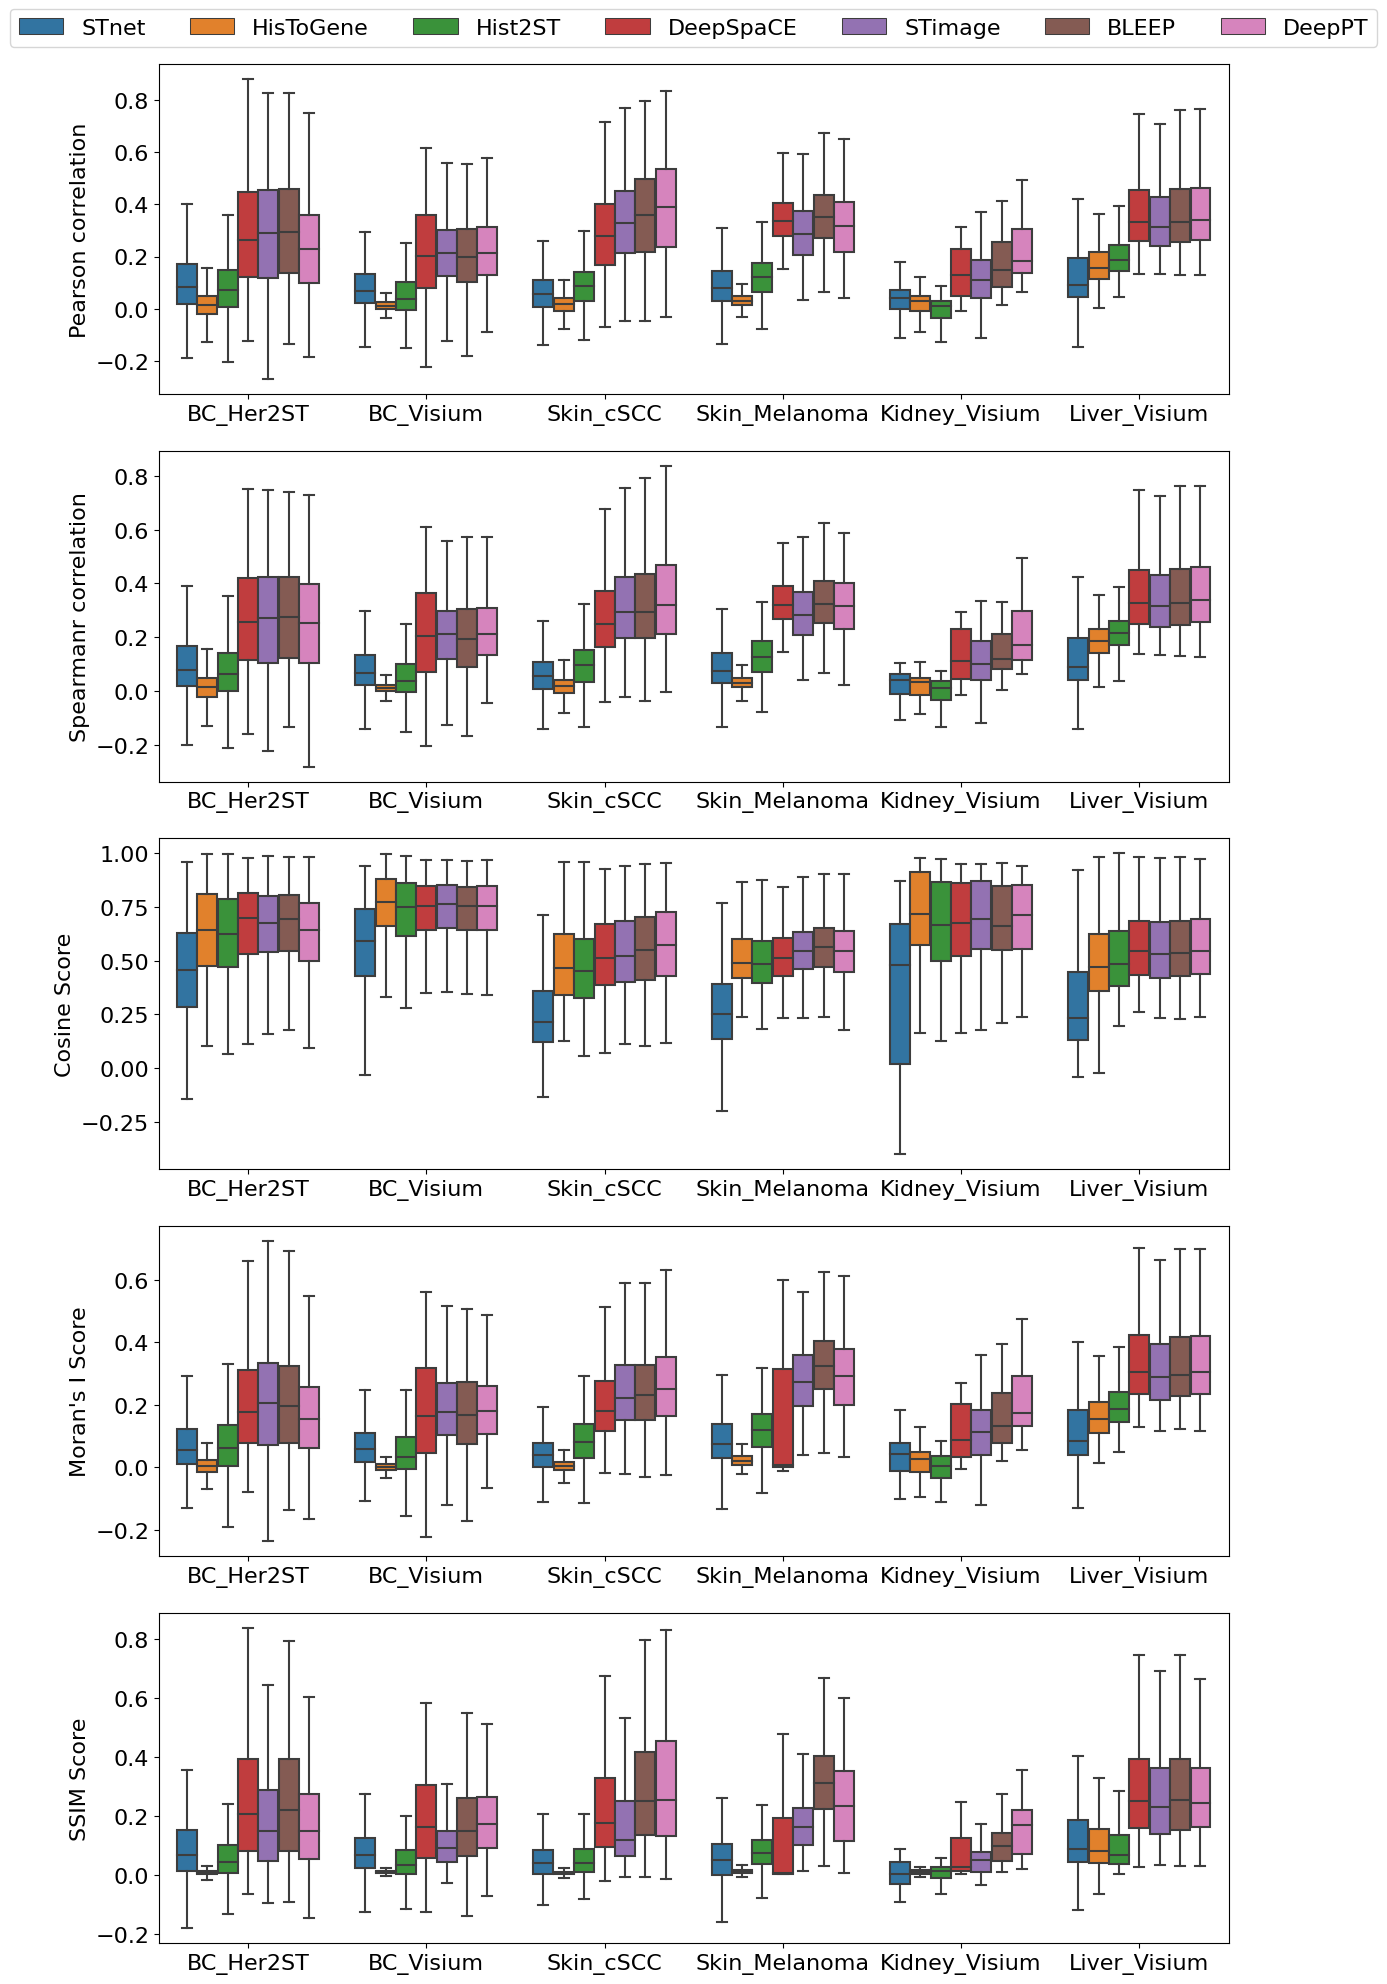

717

In [7]:
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(5, 1, figsize=(14, 20))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure2.pdf")

# Show the plotsd
plt.show()

# Collect garbage to free up memory
gc.collect()
